In [ ]:
!nvidia-smi

Sun Jun  5 05:38:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Dataset/Dataset/Ds/Copy of Rice Leaf Disease Images",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6097 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Healthy', 'Tungro']

In [ ]:
len(dataset)

191

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)

(32, 256, 256, 3)


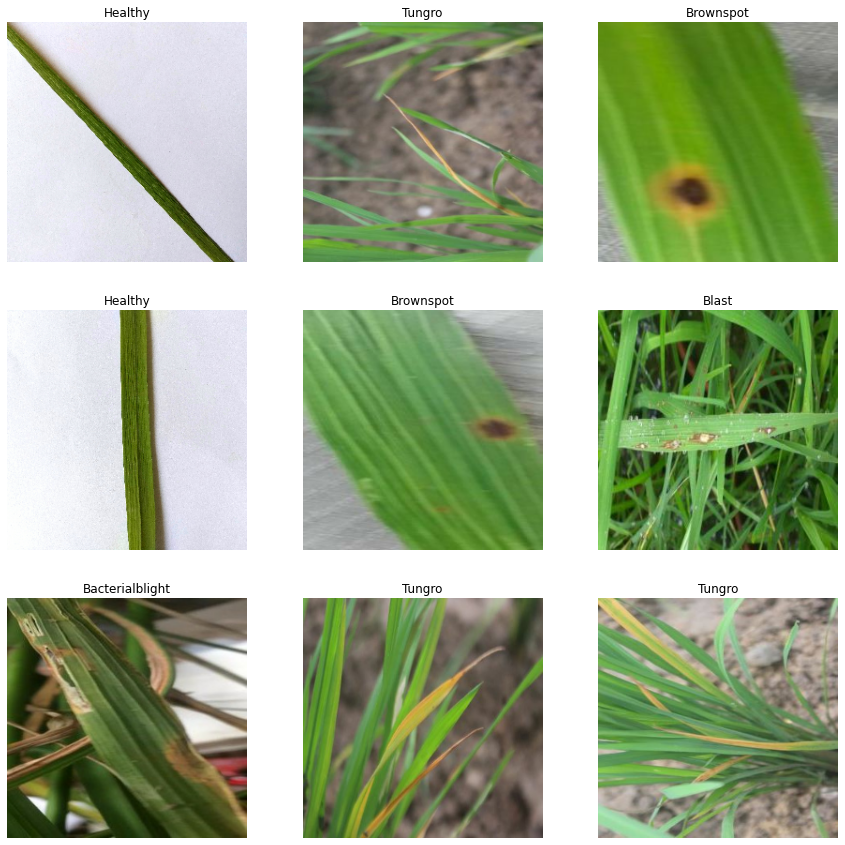

In [ ]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

**Split Dataset**

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, shuffle = True, shuffle_size = 10000):
  
  ds_size = len(ds)
  
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)
  
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  
  return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

152

In [ ]:
len(test_ds)

20

In [ ]:
len(val_ds)

19

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255)])

In [ ]:
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                         layers.experimental.preprocessing.RandomRotation(0.2),
                                         layers.experimental.preprocessing.RandomZoom(0.2)])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
                          resize_and_rescale, 
                          data_augmentation, 
                          layers.Conv2D(32,(3,3), activation="relu", input_shape = input_shape),
                          layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                          layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64, (3,3), activation="relu"),
                          layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64, (3,3), activation="relu"),
                          layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64, (3,3), activation="relu"),
                          layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64, (3,3), activation="relu"),
                          layers.MaxPooling2D((2,2)),
                          layers.Flatten(),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(n_classes, activation="softmax"),
                          ])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25
152/152 [==============================] - 1767s 610ms/step - loss: 0.9353 - accuracy: 0.6306 - val_loss: 0.9047 - val_accuracy: 0.5921
Epoch 2/25
152/152 [==============================] - 12s 76ms/step - loss: 0.6260 - accuracy: 0.7711 - val_loss: 0.5339 - val_accuracy: 0.8224
Epoch 3/25
152/152 [==============================] - 11s 75ms/step - loss: 0.5026 - accuracy: 0.8231 - val_loss: 0.4588 - val_accuracy: 0.8421
Epoch 4/25
152/152 [==============================] - 11s 74ms/step - loss: 0.4224 - accuracy: 0.8462 - val_loss: 0.3178 - val_accuracy: 0.8816
Epoch 5/25
152/152 [==============================] - 11s 74ms/step - loss: 0.3675 - accuracy: 0.8676 - val_loss: 0.3479 - val_accuracy: 0.8882
Epoch 6/25
152/152 [==============================] - 11s 73ms/step - loss: 0.3347 - accuracy: 0.8810 - val_loss: 0.3004 - val_accuracy: 0.8931
Epoch 7/25
152/152 [==============================] - 11s 73ms/step - loss: 0.2852 - accuracy: 0.8965 - val_loss: 0.2434 - val_accura

In [ ]:
score = model.evaluate(test_ds)

20/20 [==============================] - 1s 35ms/step - loss: 0.0218 - accuracy: 0.9937


In [ ]:
score

[0.021822847425937653, 0.9937499761581421]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

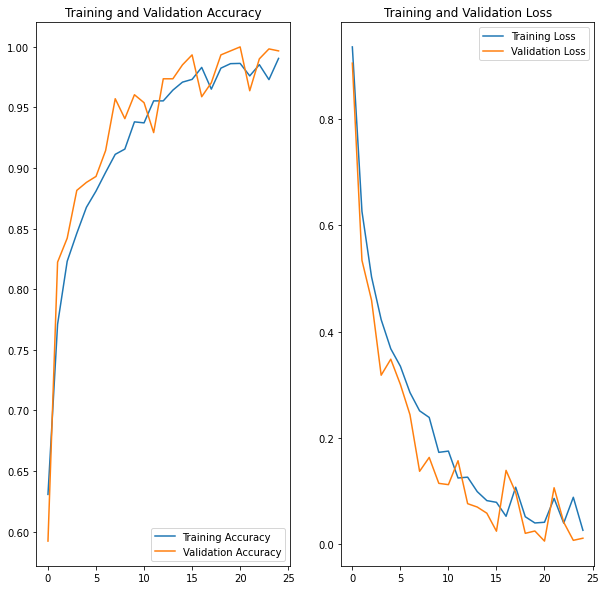

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  return predicted_class 

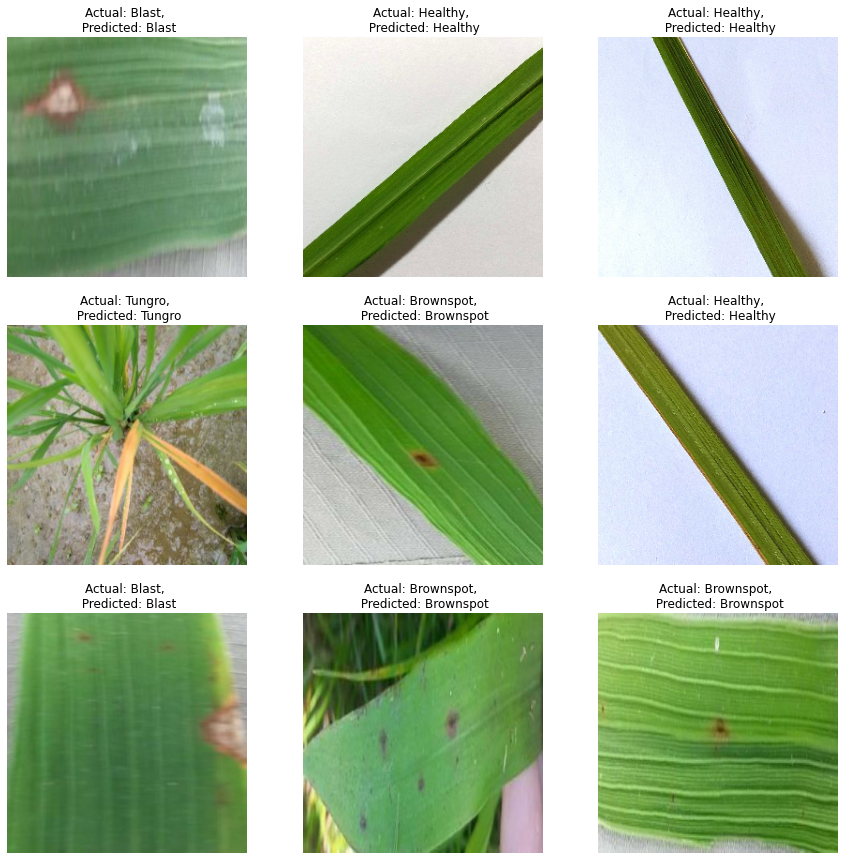

In [ ]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}")
    plt.axis("off")